In [ ]:
## Python 3.6
# ! pip install matplotlib==3.2.1 numpy==1.18.4 pandas==1.06 scipy==1.4.1 seaborn==0.10.1 tqdm==4.46.0

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats
import seaborn as sns
from tqdm import tqdm

In [3]:
from itertools import product
import pickle
import os

## Setup

* _Exposure is different for each agent, and it is drawn from a log-normal distribution (rescaled between 0 and 1)_
* _[T]wo other parameters control the probability, for each agent, to accept reliable information (Br Believe reliable) and to accept misinformation (Bm Believe misinformation). These two values are extracted, for each agent, from a normal distribution truncated between 0 and 1, with standard deviation equal to 0.1 and with mean equal to the parameter values._

In [4]:
N = 1000
T = 1000
C_m = 0.05
B_r = 0.6
B_m = 0.3

In [5]:
def make_setup(N, B_r, B_m):
    agent_exposure = np.exp(scipy.stats.multivariate_normal(0, 1).rvs(N))
    agent_exposure = agent_exposure / np.max(agent_exposure)

    agent_misinformation_acceptance = scipy.stats.truncnorm(0, 1, loc=B_m, scale=.1).rvs(N)
    agent_reliable_info_acceptance = scipy.stats.truncnorm(0, 1, loc=B_r, scale=.1).rvs(N)
    return agent_exposure, agent_misinformation_acceptance, agent_reliable_info_acceptance

## Global information score

_[A] global information score is calculated as the total number of pieces of reliable information accepted minus the total number of pieces of misinformation accepted, normalized with the overall amount of news (and then multiplied by 100 to make it more legible)_

**Implementation:**
* information - array in which each position contains -1, 0 or 1, with the following meanings:
    * -1: misinformation
    * 0: no information
    * 1: reliable information
* acceptance - array in which each position contains 0 or 1, with the meanings:
    * 0: information not accepted
    * 1: information accepted

In [6]:
def calc_global_information_score(information, acceptance):
    return 100 * np.sum(information * acceptance) / np.sum(np.abs(information))

## Dynamics

At each step, agents will:
* consume a piece of news with misinformation (-1)
* consume a piece of news with reliable information (1)
* NOT consume any piece of news (0)

Then, they will choose to believe in it or not.

For each step, we calculate the global information score

In [7]:
def sample_from_probs(probs):
    size = len(probs)
    random_array = np.random.random(size)
    return (random_array < probs).astype(np.uint8)

In [8]:
def calc_news_not_news(agent_exposure):
    return sample_from_probs(agent_exposure)

In [9]:
def is_misinformation_or_not(news_not_news, C_m):
    news_type = np.random.choice([-1, 1], size=N, p=[C_m, 1-C_m])
    return news_type * news_not_news

In [10]:
def accept_information_or_not(misinformation_or_not, agent_misinformation_acceptance, agent_reliable_info_acceptance):
    acceptance_prob = misinformation_or_not.copy().astype(np.float32)
    misinformation_indices = list(np.where(misinformation_or_not == -1)[0])
    reliable_info_indices = list(np.where(misinformation_or_not == 1)[0])

    acceptance_prob[misinformation_indices] = agent_misinformation_acceptance[misinformation_indices]
    acceptance_prob[reliable_info_indices] = agent_reliable_info_acceptance[reliable_info_indices]
    return sample_from_probs(acceptance_prob)

In [11]:
def run_iteration(agent_exposure, agent_misinformation_acceptance, agent_reliable_info_acceptance, **params):
    C_m = params["C_m"]
    
    news_not_news = calc_news_not_news(agent_exposure)
    misinformation_or_not = is_misinformation_or_not(news_not_news, C_m)
    acceptance_or_not = accept_information_or_not(misinformation_or_not, agent_misinformation_acceptance, agent_reliable_info_acceptance)
    
    return misinformation_or_not, acceptance_or_not

In [12]:
def run_simulation(T, **params):
    N = params["N"]
    B_r = params["B_r"]
    B_m = params["B_m"]
    agent_exposure, agent_misinformation_acceptance, agent_reliable_info_acceptance = make_setup(N, B_r, B_m)
    
    information = np.empty(shape=N * T)
    acceptance = np.empty(shape=N * T)
    
    all_indicators = []
    for t in range(T):
        misinformation_or_not, acceptance_or_not = run_iteration(
            agent_exposure, agent_misinformation_acceptance, agent_reliable_info_acceptance, **params)
        
        information[N * t : N * (t+1)] = misinformation_or_not
        acceptance[N * t : N * (t+1)] = acceptance_or_not
        
    return calc_global_information_score(information, acceptance)

## Simulations

In [13]:
use_cache = (os.path.exists("results.pkl"))

In [14]:
simulation_results = []
for extra_B_r in tqdm(np.arange(0. , 0.11, 0.01)):
    if use_cache:
        continue
    for i in range(10):
        params = {
            "N": N,
            "C_m": C_m,
            "B_m": B_m,
            "B_r": B_r + extra_B_r,
        }
        global_information_score = run_simulation(T, **params)
        simulation_results.append({
            "improvement_in_B_r": extra_B_r,
            "global_information_score": global_information_score
        })

100%|██████████| 11/11 [00:00<00:00, 32652.05it/s]


In [15]:
misinformation_to_zero_results = []
for i in range(10):
    if use_cache:
        continue
    
    params = {
        "N": N,
        "C_m": C_m,
        "B_m": 0.,
        "B_r": B_r,
    }
    global_information_score = run_simulation(T, **params)
    misinformation_to_zero_results.append(global_information_score)

In [16]:
total = 2 * len(list(product(np.arange(0., 0.11, 0.01), np.arange(0.01, 0.11, 0.01))))

In [17]:
reliable_info_vs_misinformation_rate_results = []
for different_B_m, different_C_m, extra_B_r in tqdm(
    product([0., B_m], np.arange(0.01, 0.11, 0.01), np.arange(0., 0.11, 0.01)), total=total):
    
    if use_cache:
        continue
    
    for i in range(10):
        params = {
            "N": N,
            "C_m": different_C_m,
            "B_m": different_B_m,
            "B_r": B_r + extra_B_r,
        }
        global_information_score = run_simulation(T, **params)
        reliable_info_vs_misinformation_rate_results.append({
            "C_m": params["C_m"],
            "B_r": params["B_r"],
            "B_m": params["B_m"],
            "global_information_score": global_information_score
        }) 

100%|██████████| 220/220 [00:00<00:00, 279112.79it/s]


In [18]:
## Cache
if not use_cache:
    results = (simulation_results, misinformation_to_zero_results, reliable_info_vs_misinformation_rate_results)
    with open("results.pkl", "wb") as f:
        pickle.dump(results, f)

In [19]:
with open("results.pkl", "rb") as f:
    simulation_results, misinformation_to_zero_results, \
        reliable_info_vs_misinformation_rate_results = pickle.load(f)

## Results

In [20]:
results_df = pd.DataFrame(simulation_results)

In [21]:
subset_results_df = results_df[results_df["improvement_in_B_r"] > 0]
subset_results_df["Percentage of improvement acceptance of reliable information"] = (
    100 * subset_results_df["improvement_in_B_r"]).astype(int)

/home/cin/.local/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [22]:
baseline = results_df[results_df["improvement_in_B_r"] == 0]["global_information_score"].mean()

In [23]:
intervention_in_misinformation = np.mean(misinformation_to_zero_results)

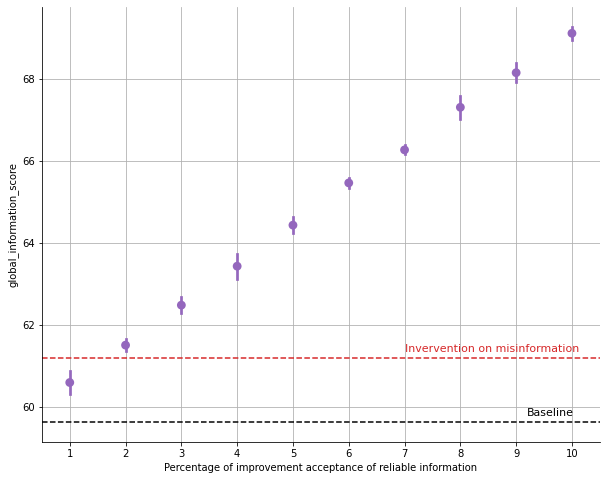

In [24]:
plt.figure(figsize=(10, 8))
sns.pointplot(x="Percentage of improvement acceptance of reliable information", y="global_information_score", 
              data=subset_results_df, join=False, ci="sd", color="tab:purple")

plt.axhline(baseline, color="black", linestyle="--")
plt.text(8.2, baseline + 0.15, "Baseline", color="black", fontsize=11)


plt.axhline(intervention_in_misinformation, color="tab:red", linestyle="--")
plt.text(6, intervention_in_misinformation + 0.15, "Invervention on misinformation", color="tab:red", fontsize=11)
sns.despine()
plt.grid()

### Misinformation rate vs. Reliable info acceptance

In [25]:
reliable_info_vs_misinformation_rate_results_df = pd.DataFrame(reliable_info_vs_misinformation_rate_results)

In [26]:
subset_misinformation_to_zero_df = (
    reliable_info_vs_misinformation_rate_results_df[
        (reliable_info_vs_misinformation_rate_results_df["B_m"] == 0) &
        (reliable_info_vs_misinformation_rate_results_df["B_r"] == B_r)
    ]
    .groupby(["C_m", "B_r"])
    .agg({"global_information_score": "mean"})
    .reset_index()
    .rename(columns={"global_information_score": "global_information_score_zero"})
)
subset_misinformation_kept_non_zero_df = (
    reliable_info_vs_misinformation_rate_results_df[
        reliable_info_vs_misinformation_rate_results_df["B_m"] > 0]
    .groupby(["C_m", "B_r"])
    .agg({"global_information_score": "mean"})
    .reset_index()
    .rename(columns={"global_information_score": "global_information_score_non_zero"})
)

In [27]:
subset_misinformation_kept_non_zero_df = (
    subset_misinformation_kept_non_zero_df
        .merge(subset_misinformation_to_zero_df.drop("B_r", axis=1), on=["C_m"], how="left")
)
subset_misinformation_kept_non_zero_df["diff_global_information_score"] = (
    subset_misinformation_kept_non_zero_df["global_information_score_non_zero"] - 
    subset_misinformation_kept_non_zero_df["global_information_score_zero"]
)

In [28]:
subset_misinformation_kept_non_zero_df["extra_B_r"] = round(100 * (subset_misinformation_kept_non_zero_df["B_r"] - B_r)).astype(int)
subset_misinformation_kept_non_zero_df["C_m"] = (100 * subset_misinformation_kept_non_zero_df["C_m"]).astype(int)

In [29]:
formatted_df = pd.pivot_table(
    subset_misinformation_kept_non_zero_df,
    index=["extra_B_r"],
    columns=["C_m"],
    values=["diff_global_information_score"]
).sort_values(by=["extra_B_r"], ascending=False)

In [30]:
formatted_df.columns = formatted_df.columns.droplevel()

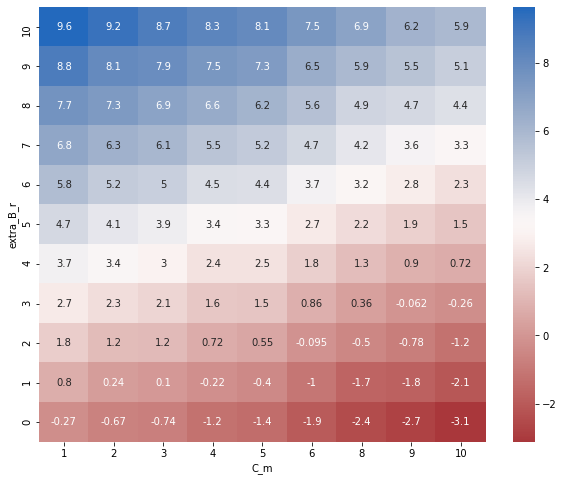

In [31]:
plt.figure(figsize=(10, 8))
sns.heatmap(formatted_df, cmap="vlag_r",annot=True)
plt.show()